In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

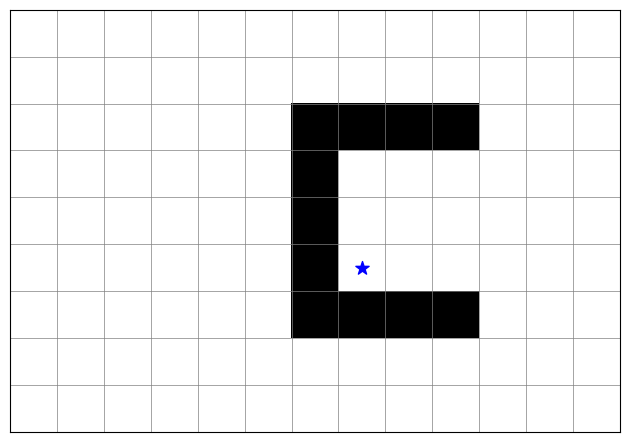

In [33]:
# define maze
maze = np.zeros((9, 13))

# place walls
maze[2, 6:10] = 1
maze[-3, 6:10] = 1
maze[2:-3, 6] = 1

# define start
start = [5, 7]

def plot_maze(maze):
    plt.imshow(maze, cmap='binary')

    # draw thin grid
    for i in range(maze.shape[0]):
        plt.plot([-0.5, maze.shape[1]-0.5], [i-0.5, i-0.5], c='gray', lw=0.5)
    for i in range(maze.shape[1]):
        plt.plot([i-0.5, i-0.5], [-0.5, maze.shape[0]-0.5], c='gray', lw=0.5)

    plt.xticks([])
    plt.yticks([])

plot_maze(maze)
plt.scatter(start[1], start[0], marker='*', color='blue', s=100)
plt.tight_layout()
# plt.savefig('maze.png')
plt.show()

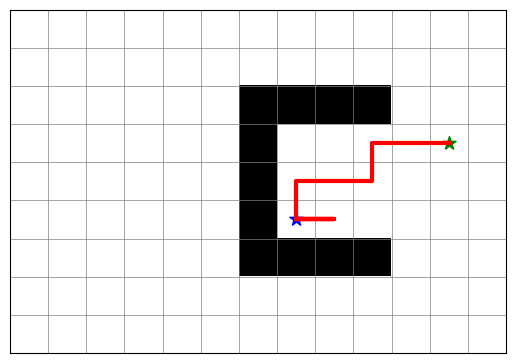

In [43]:
####################################
############## Part 1 ##############
####################################


def random_walk(maze, start, n_steps):
    # perform a single random walk in the given maze, starting from start, performing n_steps random moves
    # moves into the wall and out of the maze boundary are not possible

    # initialize list to store positions
    positions = [start]
    
    # define possible moves as dictionary 
    moves = {
        'up': (0, -1),
        'down': (0, 1),
        'left': (-1, 0),
        'right': (1, 0)
    }
    
    # perform random steps
    for _ in range(n_steps):
        # get current position
        current_position = positions[-1].copy()  # get current position
        valid_move_found = False  # flag to track if a valid move is made
        
        # try random moves until a valid move is found
        while not valid_move_found:
            move = np.random.choice(['up', 'down', 'left', 'right'])
            dx, dy = moves[move]
            new_position = [current_position[0] + dx, current_position[1] + dy]
            
            # check if new_position is within maze boundaries and not a wall
            if (0 <= new_position[0] < maze.shape[0] and  # x boundary check
                0 <= new_position[1] < maze.shape[1] and  # y boundary check
                maze[new_position[0], new_position[1]] == 0):  # check if not a wall
                # if move is valid, append new_position to positions
                positions.append(new_position)
                valid_move_found = True  # set flag to exit loop after valid move

    # return a list of length n_steps + 1, containing the starting position and all subsequent locations as e.g. tuples or size (2) arrays 
    return positions

def plot_path(maze, path):
    # plot a maze and a path in it
    plot_maze(maze)
    path = np.array(path)
    plt.plot(path[:, 1], path[:, 0], c='red', lw=3)
    plt.scatter(path[0, 1], path[0, 0], marker='*', color='blue', s=100)
    plt.scatter(path[-1, 1], path[-1, 0], marker='*', color='green', s=100)
    plt.show()

# plot a random path
path = random_walk(maze, start, 10)
plot_path(maze, path)

The random walk is defined by all possibles moves from a certain field - only to neighboring positions and after checking if there is a wall on the new position. Then one of the possible new positions is chosen randomly. 
We can see that the trajcetory successfully avoids the wall and moves in random manner - each new execution reveals different paths. The more steps one uses the more likely it is that the distance from the start position increases since there are also many "backwards" steps happening. 

  0%|          | 0/5001 [00:00<?, ?it/s]

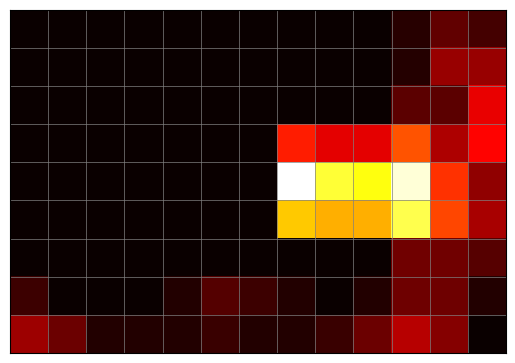

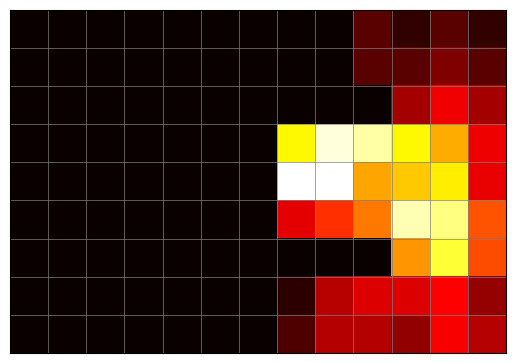

  2%|▏         | 89/5001 [00:00<00:16, 297.06it/s]

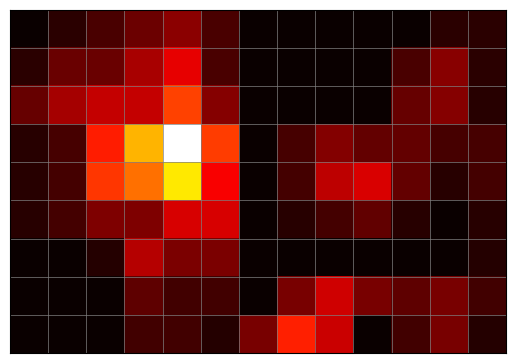

 19%|█▉        | 971/5001 [00:02<00:09, 410.40it/s]

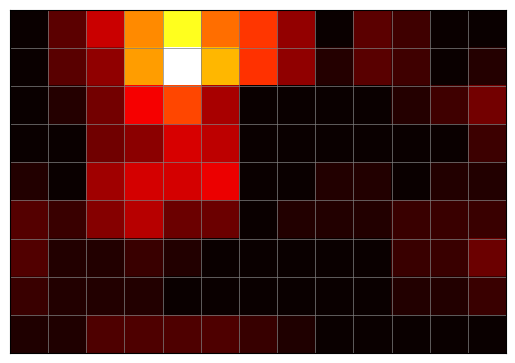

100%|█████████▉| 4998/5001 [00:12<00:00, 412.14it/s]

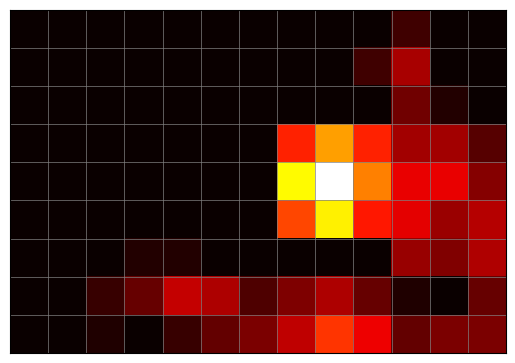

100%|██████████| 5001/5001 [00:12<00:00, 390.43it/s]


In [35]:
####################################
############## Part 2 ##############
####################################



def learn_from_traj(succ_repr, trajectory, gamma=0.98, alpha=0.02):
    # Write a function to update a given successor representation (for the state at which the trajectory starts) using an example trajectory
    # using discount factor gamma and learning rate alpha   

    # calculate the discount factor 
    gamma = np.array([gamma**i for i in range(len(trajectory))])
    # create matrix of maze with discount factor 
    succ_repr = np.zeros_like(maze)

    # update the successor representation
    for i,j in trajectory:
        succ_repr[i, j] += alpha * (gamma[i])

    # return the updated successor representation
    return succ_repr

# initialize successor representation
succ_repr = np.zeros_like(maze)

# sample a whole bunch of trajectories (reduce this number if this code takes too long, but it shouldn't take longer than a minute with reasonable code)
for i in tqdm(range(5001)):
    # sample a path (we use 340 steps here to sample states until the discounting becomes very small)
    path = random_walk(maze, start, 340)
    # update the successor representation
    succ_repr = learn_from_traj(succ_repr, path, alpha=0.02)  # choose a small learning rate

    # occasionally plot it
    if i in [0, 10, 100, 1000, 5000]:
        plot_maze(maze)
        plt.imshow(succ_repr, cmap='hot')
        # if i == 5000:
        #     plt.savefig("empirical")
        plt.show()

A vector gamma is computed by multiplying it with itself i times (i = position in trajectory) reflecting the contribution of each state along the trajectory based on its distance from the start so that future states are weighted less as their distance from the start increases.  For each state in the trajectory the successor representation is weighted by the learning rate alpha. 
The successor representation is initiated by zero matrix but then for different random walks which are created the probabily of following states are created and states with high probability have red colours. 

In [36]:
####################################
############## Part 3 ##############
####################################



def compute_transition_matrix(maze):
    # for a given maze, compute the transition matrix from any state to any other state under a random walk policy
    # (you will need to think of a good way to map any 2D grid coordinates onto a single number for this)

    # create a matrix over all state pairs
    transitions = np.zeros((maze.size, maze.size))


    # iterate over all states, filling in the transition probabilities to all other states on the next step (only one step into the future)
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            # check if the cell is a wall
            if maze[i, j] == 1:
                continue

            # get the index of the current state
            current_state = i * maze.shape[1] + j

            # get possible moves
            possible_moves = []
            for move in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                new_position = (i + move[0], j + move[1])
                if new_position[0] >= 0 and new_position[0] < maze.shape[0] and new_position[1] >= 0 and new_position[1] < maze.shape[1] and maze[new_position] == 0:
                    possible_moves.append(new_position)

            # compute the probability of moving to each of the possible moves
            for move in possible_moves:
                new_state = move[0] * maze.shape[1] + move[1]
                transitions[current_state, new_state] = 1 / len(possible_moves)

    


    # remove NaNs if necessary
    transitions = np.nan_to_num(transitions)
    

    return transitions

The 2d coordinates are mapped by adding the two indices of the postion together into the postion of an array determined by the number of one of the indices. Then the transition matrix is calculated by defining moves to neighboring fields and then the probability of moving to each field by dividing by the number of fields. Hereby, we check if a field includes a wall and exclude it from the possible moves. 

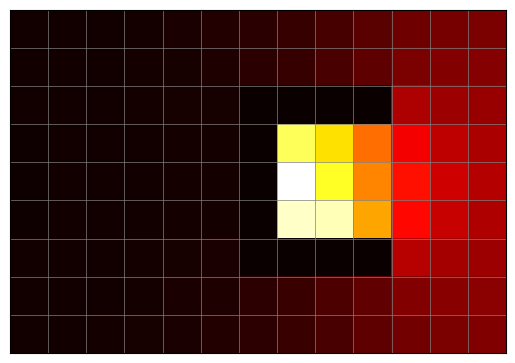

In [37]:
####################################
############## Part 4 ##############
####################################

def compute_sr(transitions, i, j, gamma=0.98):
    # given a transition matrix and a specific state (i, j), compute the successor representation of that state with discount factor gamma

    # initialize things (better to represent the current discounted occupancy as a vector here)
    current_discounted_occupancy = np.zeros(transitions.shape[0])
    total = current_discounted_occupancy.copy()
    
    # set the current state
    current_state = i * maze.shape[1] + j
    
    current_discounted_occupancy[current_state] = 1



    # iterate for a number of steps
    for _ in range(340):
        
        # update the current discounted occupancy
        current_discounted_occupancy = transitions @ (gamma * current_discounted_occupancy)
        # add it to the total
        total += current_discounted_occupancy


    # return the successor representation, maybe reshape your vector into the maze shape now
    return total.reshape(maze.shape)

transitions = compute_transition_matrix(maze)

# compute state representation for start state
i, j = start
sr = compute_sr(transitions, i, j, 0.98)

# plot state representation
plot_maze(maze)
plt.imshow(sr, cmap='hot')
# plt.savefig("transition_iterate")
plt.show()

The future state occupancy is initialized to zero. We create a vector representing the current state's influence which is set to 1 for the starting position.  Then we calculate the discounted occupancy of all following states by multiplying the transition matrix with the discounted occupancy weighted by gamma. The result is added up for each iteration. 

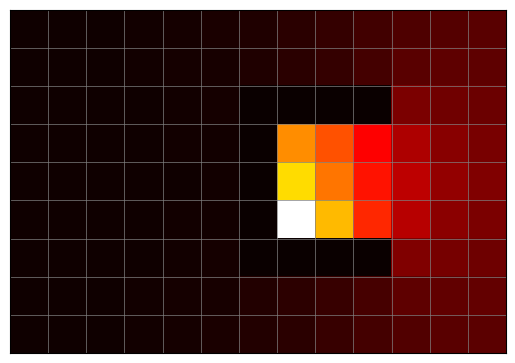

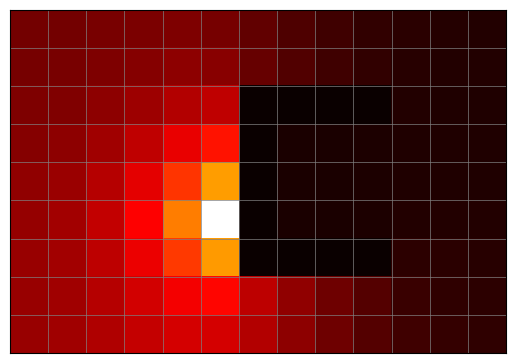

In [44]:
############################################
############## Part 5 (Bonus) ##############
############################################

"""Compute the successor representation one last time, for all states at once, using the analytical equation which involves the transition matrix (in a way that does not require the repeated application of the transition matrix, as you did in the previous exercise). Extract and plot the successor representation of the starting state, as well the representation of the state on the opposite side of the wall from the starting state (2 steps to the left).
"""

def compute_sr_analytical(transitions, gamma=0.98):
    # compute the successor representation for all states at once using the analytical equation

    # compute the successor representation using the analytical equation
    sr = np.eye(transitions.shape[0]) - gamma * transitions.T

    sr = np.linalg.inv(sr)

    return sr

transitions = compute_transition_matrix(maze)

# compute the successor representation using the analytical equation
sr = compute_sr_analytical(transitions)


start1 = [5,7]
start2 = [5,5]
# plot state representation for start state
i, j = start1
sr_start = sr[i * maze.shape[1] + j].reshape(maze.shape)
plot_maze(maze)
plt.imshow(sr_start, cmap='hot')
# plt.savefig("analytical_start")
plt.show()

i, j = start2
sr_start = sr[i * maze.shape[1] + j].reshape(maze.shape)
plot_maze(maze)
plt.imshow(sr_start, cmap='hot')
# plt.savefig("analytical_start")
plt.show()


The analytical solution is calculated by multiplying the transition matrix with gamma and substracting it from the unity matrix. The result is the same as for the previous exercise solution. When changing the starting postion the representation successfully switches. 